In [29]:
import glob
import os
from abc import ABC
from typing import Awaitable, Callable

import tiktoken
from azure.core.credentials import AzureKeyCredential
from azure.core.credentials_async import AsyncTokenCredential
from azure.core.exceptions import ResourceExistsError
from azure.identity.aio import AzureDeveloperCliCredential, get_bearer_token_provider
from azure.search.documents.aio import SearchClient
from azure.search.documents.indexes._generated.models import (
    NativeBlobSoftDeleteDeletionDetectionPolicy,
)
from azure.search.documents.indexes.aio import SearchIndexClient, SearchIndexerClient
from azure.search.documents.indexes.models import (
    AzureOpenAIEmbeddingSkill,
    AzureOpenAIParameters,
    AzureOpenAIVectorizer,
    FieldMapping,
    IndexProjectionMode,
    HnswAlgorithmConfiguration,
    HnswParameters,
    InputFieldMappingEntry,
    OutputFieldMappingEntry,
    SearchableField,
    SearchField,
    SearchFieldDataType,
    SearchIndex,
    SearchIndexer,
    SearchIndexerDataContainer,
    SearchIndexerDataSourceConnection,
    SearchIndexerIndexProjections,
    SearchIndexerIndexProjectionSelector,
    SearchIndexerIndexProjectionsParameters,
    SearchIndexerSkillset,
    SemanticConfiguration,
    SemanticField,
    SemanticPrioritizedFields,
    SemanticSearch,
    SimpleField,
    SplitSkill,
    VectorSearch,
    VectorSearchProfile,
    VectorSearchVectorizer,
)
from azure.storage.blob.aio import BlobServiceClient
from dotenv import load_dotenv
from openai import AsyncAzureOpenAI, AsyncOpenAI, RateLimitError
from tenacity import (
    AsyncRetrying,
    retry_if_exception_type,
    stop_after_attempt,
    wait_random_exponential,
)
from typing_extensions import TypedDict

from app.backend.prepdocslib.blobmanager import BlobManager
from app.backend.prepdocslib.listfilestrategy import File, LocalListFileStrategy

load_dotenv(".azure/hhgai-dev-eastus-001/.env")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## `LocalListFileStrategy` and `File`

**Note:** Make sure you delete the md5 hashes in the `data` folder before running the following cells.


In [2]:
# First remove all md5 hashes to reupload the files
def remove_md5_hashes(path: str):
    for md5_file in glob.glob(path, recursive=True):
        if os.path.exists(md5_file):
            os.remove(md5_file)
            print(f"Removed {os.path.basename(md5_file)}")


remove_md5_hashes(os.path.join("data", "*.md5"))

In [3]:
local_files = "./data/*"
list_file_strategy = LocalListFileStrategy(path_pattern=local_files)

In [4]:
# Prints out all paths (ignores directories)
async for p in list_file_strategy.list_paths():
    print(p)

./data/6 Mental Wellness Tips to_1445385.txt
./data/3 Habits You Need to Mana_1444150.txt
./data/A Healthy Life Begins in _1445871.txt
./data/Building Strong Family Ti_1445924.txt


In [5]:
# Generates md5 hashes
async for file in list_file_strategy.list():
    print(f"Filename: {file.filename()}")
    print(f"File extension: {file.file_extension()}")
    print(f"Attached ID to filename: {file.filename_to_id().split('-')[-1]}")
    print()
    file.close()  # close

Filename: 6 Mental Wellness Tips to_1445385.txt
File extension: .txt
Attached ID to filename: 36204D656E74616C2057656C6C6E657373205469707320746F5F313434353338352E747874

Filename: 3 Habits You Need to Mana_1444150.txt
File extension: .txt
Attached ID to filename: 332048616269747320596F75204E65656420746F204D616E615F313434343135302E747874

Filename: A Healthy Life Begins in _1445871.txt
File extension: .txt
Attached ID to filename: 41204865616C746879204C69666520426567696E7320696E205F313434353837312E747874

Filename: Building Strong Family Ti_1445924.txt
File extension: .txt
Attached ID to filename: 4275696C64696E67205374726F6E672046616D696C792054695F313434353932342E747874



In [6]:
# Check md5 hashes were already generated
async for p in list_file_strategy.list_paths():
    file = File(content=open(p, mode="rb"))  # convert to File object from filepath
    print(f"md5 hash exists for file {file.filename()}: {list_file_strategy.check_md5(p)}")

md5 hash exists for file 6 Mental Wellness Tips to_1445385.txt: True
md5 hash exists for file A Healthy Life Begins in _1445871.txt.md5: True
md5 hash exists for file 3 Habits You Need to Mana_1444150.txt: True
md5 hash exists for file 3 Habits You Need to Mana_1444150.txt.md5: True
md5 hash exists for file A Healthy Life Begins in _1445871.txt: True
md5 hash exists for file 6 Mental Wellness Tips to_1445385.txt.md5: True
md5 hash exists for file Building Strong Family Ti_1445924.txt.md5: True
md5 hash exists for file Building Strong Family Ti_1445924.txt: True


## `BlobServiceClient`


In [7]:
storage_account: str = os.getenv("AZURE_STORAGE_ACCOUNT")  # name of storage account
# container: str = os.getenv("AZURE_STORAGE_CONTAINER")  # name of container
container: str = "contenttemp"  # please use a temporary container name for testing
tenantid: str | None = os.getenv("AZURE_TENANT_ID")  # None
storage_key: str | None = None  # we're not using keys

# Use the current user identity to connect to Azure services unless a key is explicitly set for any of them
azure_credential = (
    AzureDeveloperCliCredential()
    if tenantid is None
    else AzureDeveloperCliCredential(tenant_id=tenantid, process_timeout=60)
)

storage_creds: AsyncTokenCredential | str = azure_credential if storage_key is None else storage_key

# Blob service client
blob_service = BlobServiceClient(
    account_url=f"https://{storage_account}.blob.core.windows.net", credential=storage_creds
)

### Removing from Blob Storage


Specify an existing file path in the `path` variable or use `None` to remove all files in the container.


In [8]:
# List a certain file (blob) in the container or relative path in local
# Specify None for path to remove all blobs in the container
path: str | None = None

# Using context manager to get blob service client and container client
async with BlobServiceClient(
    account_url=f"https://{storage_account}.blob.core.windows.net", credential=storage_creds
) as service_client, service_client.get_container_client(container) as container_client:

    # Check if container already exists in Azure Blob Storage
    exists = await container_client.exists()
    print(f"Container exists: {exists}")
    if not exists:
        print("Container doesn't exist. There's nothing to remove.")
    else:
        # If no path is specified, we list out all blob paths in the container
        if path is None:
            prefix = None
            blobs = container_client.list_blob_names()
        # If path is specified, we list out all blob paths in the container that
        # matches or start with the specified prefix
        else:
            prefix = os.path.splitext(os.path.basename(path))[0]
            blobs = container_client.list_blob_names(name_starts_with=prefix)

        async for blob_path in blobs:
            print("Removing blob %s", blob_path)
            await container_client.delete_blob(blob_path)

Container exists: False
Container doesn't exist. There's nothing to remove.


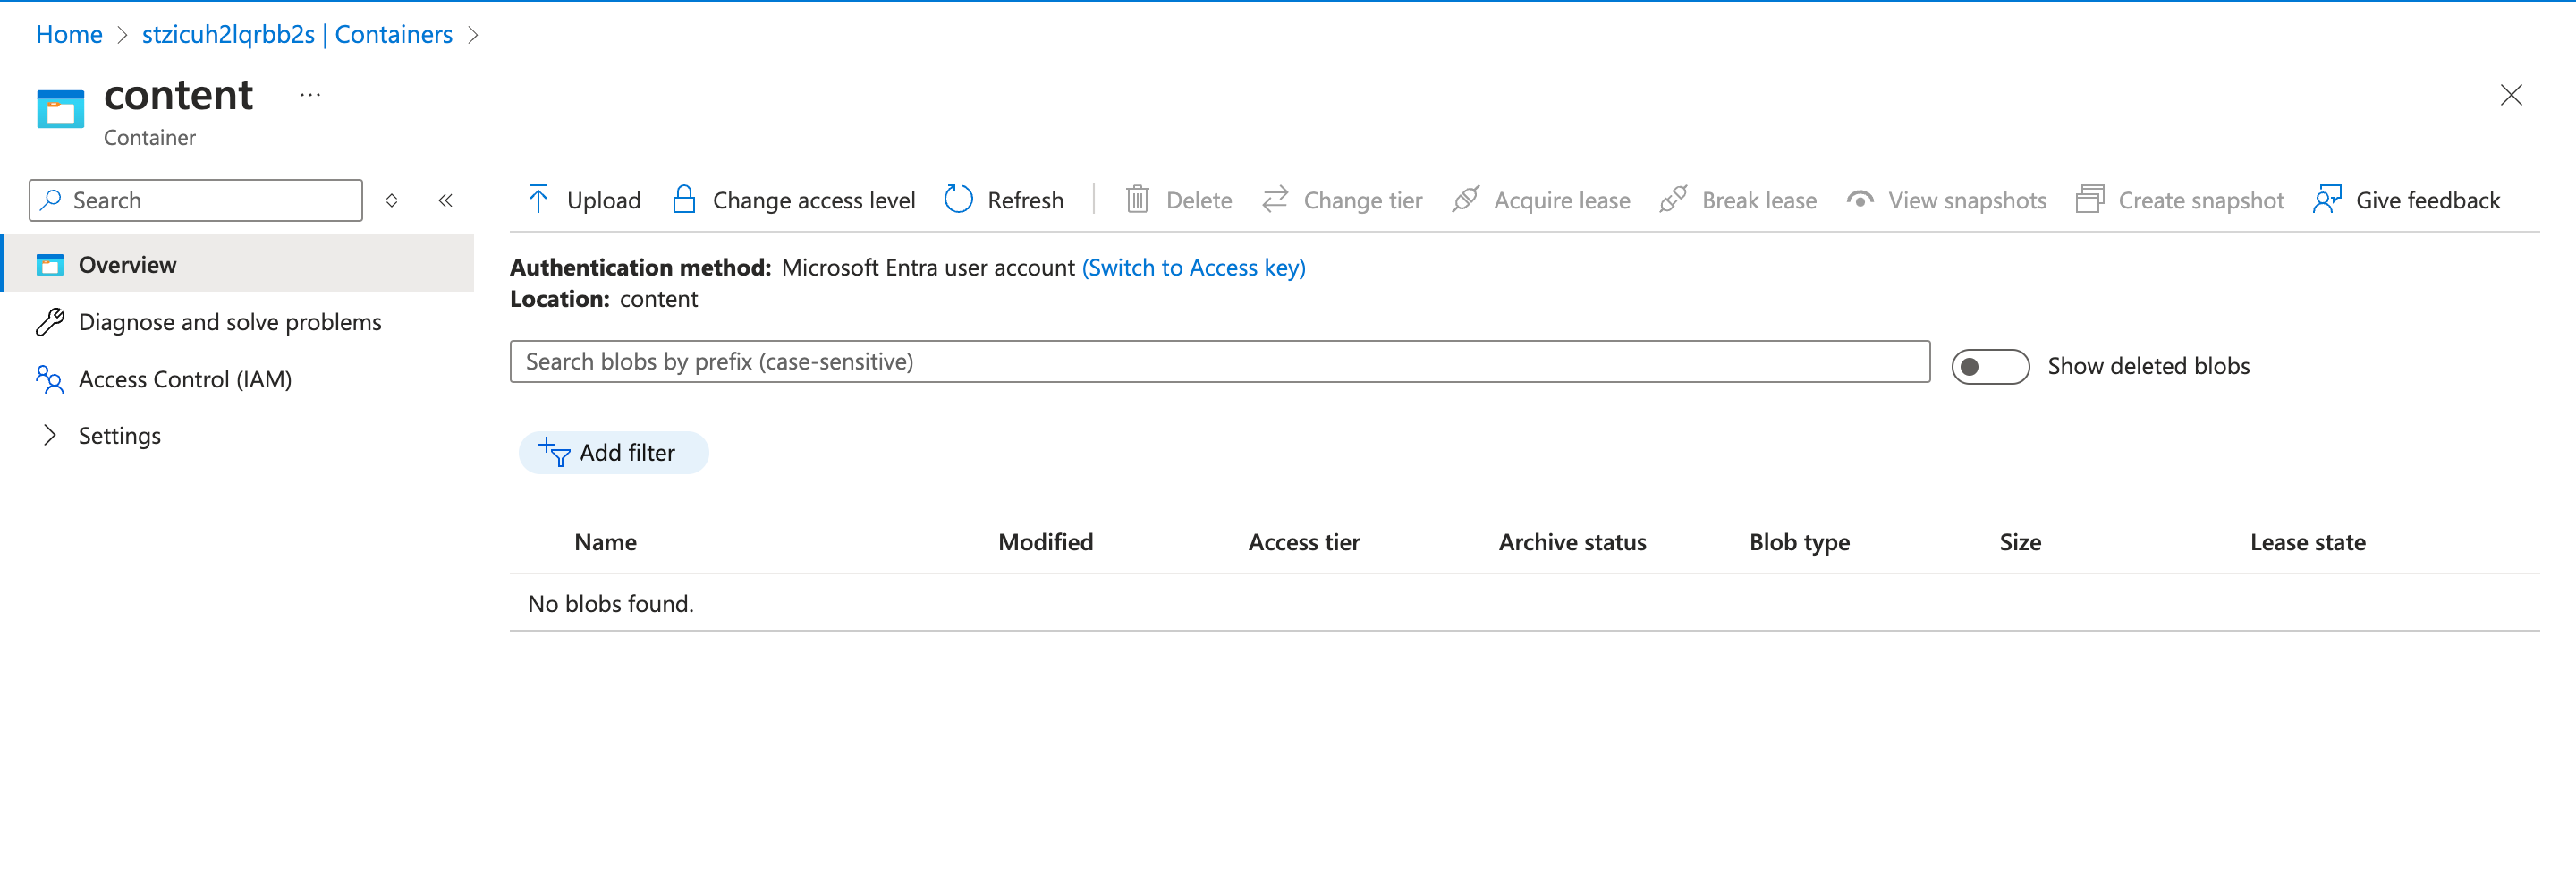


### Uploading to Blob Storage


In [9]:
# First remove all md5 hashes to reupload the files
remove_md5_hashes(os.path.join("data", "*.md5"))

Removed A Healthy Life Begins in _1445871.txt.md5
Removed 3 Habits You Need to Mana_1444150.txt.md5
Removed 6 Mental Wellness Tips to_1445385.txt.md5
Removed Building Strong Family Ti_1445924.txt.md5


In [10]:
# Using context manager to get blob service client and container client
async with BlobServiceClient(
    account_url=f"https://{storage_account}.blob.core.windows.net",
    credential=storage_creds,
    max_single_put_size=4 * 1024 * 1024,
) as service_client, service_client.get_container_client(container) as container_client:

    # Check if container already exists in Azure Blob Storage
    exists = await container_client.exists()
    print(f"Container exists: {exists}")
    if not exists:
        print(f"Container doesn't exist. Creating container {container}.")
        await container_client.create_container()

    # List all the local files
    async for file in list_file_strategy.list():
        if file.url is None:
            with open(file.content.name, "rb") as reopened_file:
                # @classmethod - gets the basename of the file
                blob_name = BlobManager.blob_name_from_file_name(file.content.name)
                print("Uploading blob for whole file -> %s", blob_name)
                blob_client = await container_client.upload_blob(blob_name, reopened_file, overwrite=True)
                file.url = blob_client.url

Container exists: False
Container doesn't exist. Creating container contenttemp.
Uploading blob for whole file -> %s 6 Mental Wellness Tips to_1445385.txt
Uploading blob for whole file -> %s 3 Habits You Need to Mana_1444150.txt
Uploading blob for whole file -> %s A Healthy Life Begins in _1445871.txt
Uploading blob for whole file -> %s Building Strong Family Ti_1445924.txt


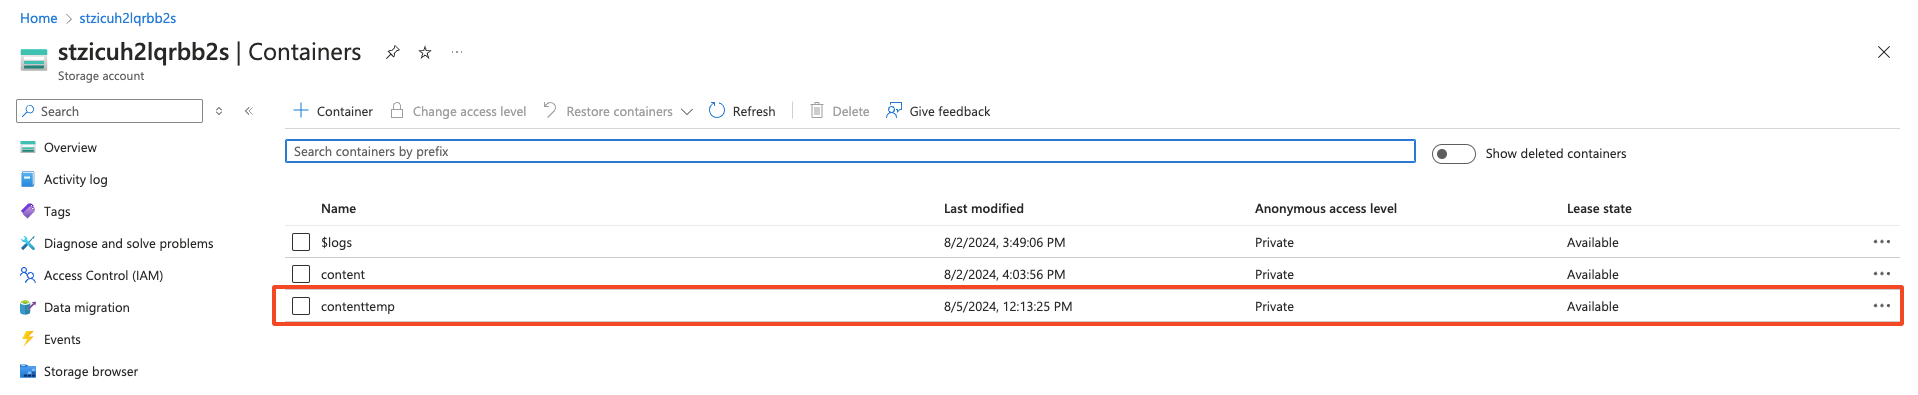


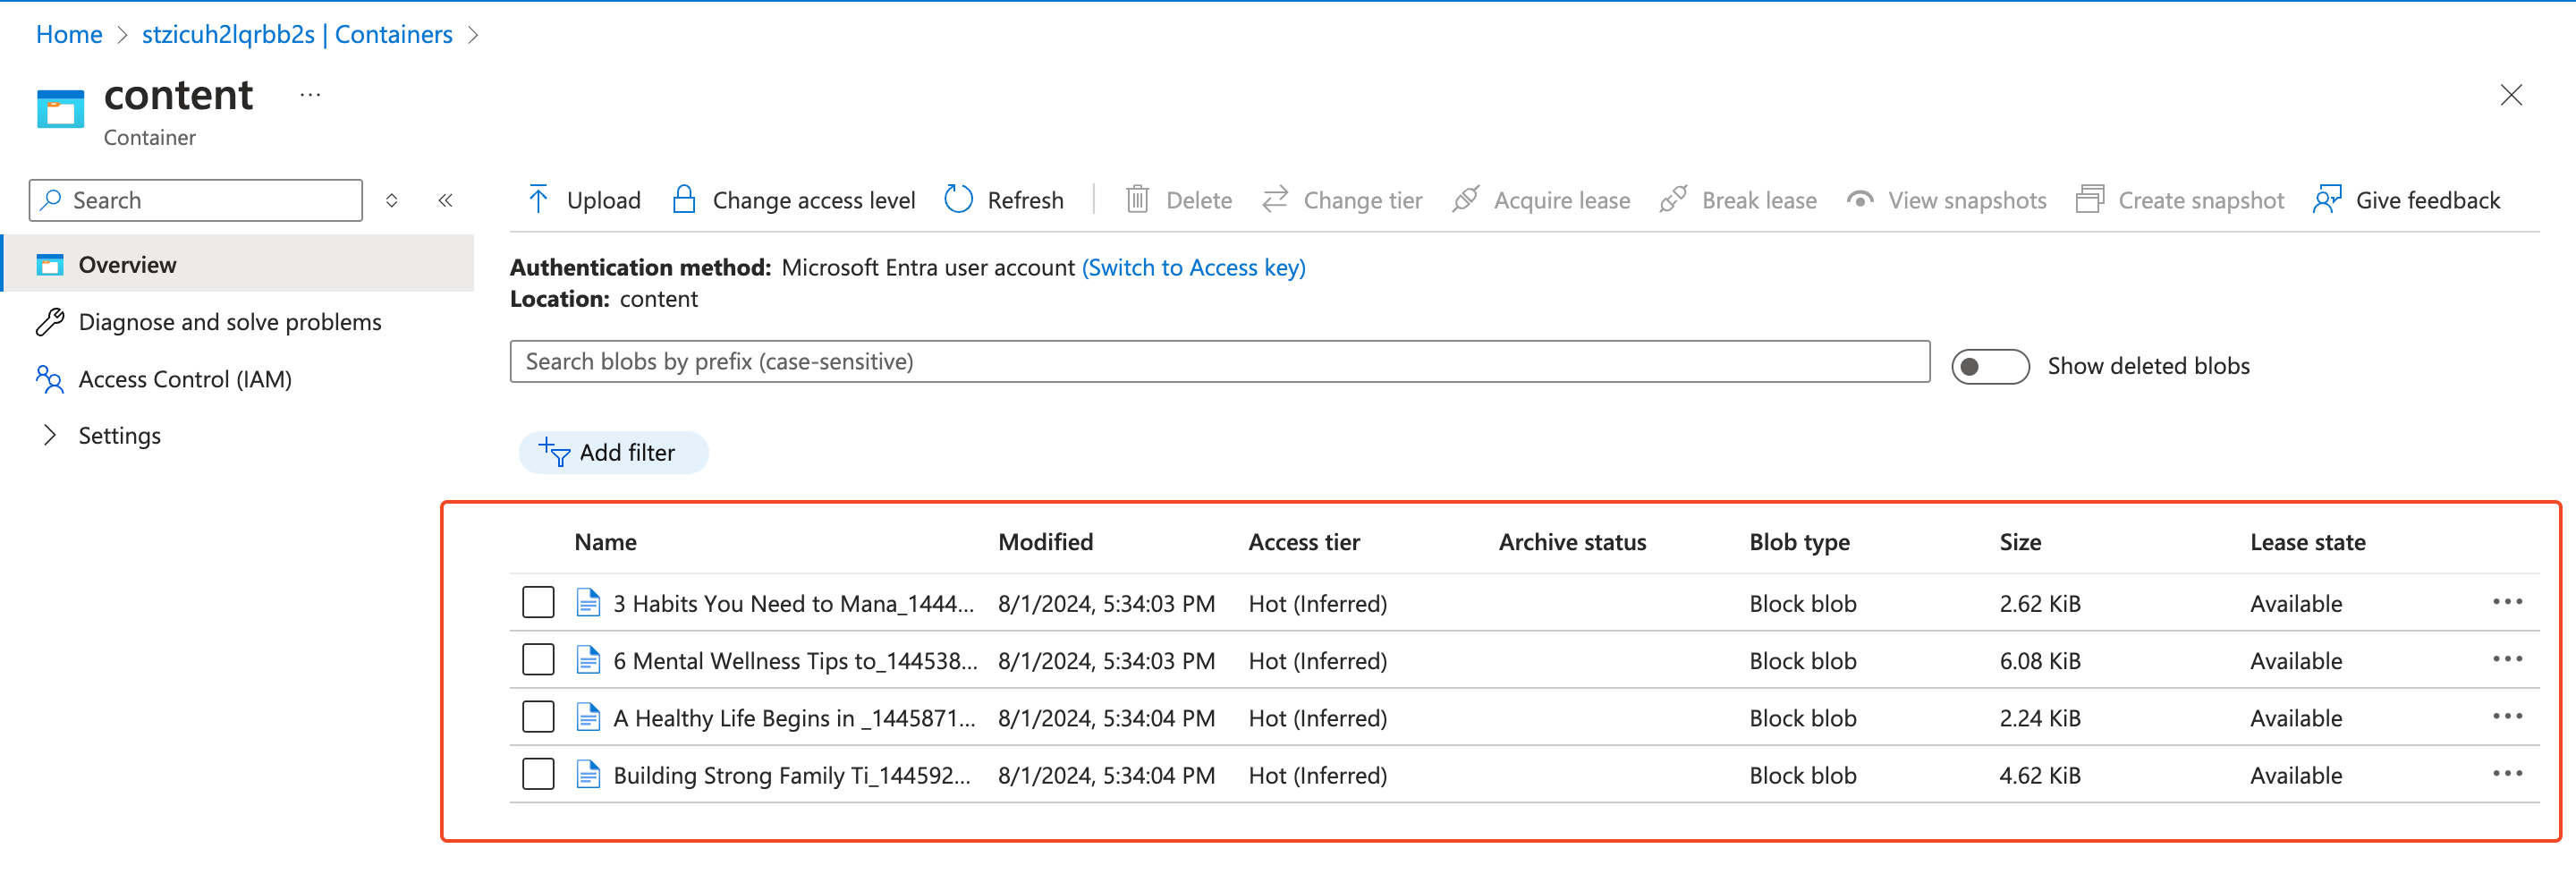


In [11]:
print(file.url)

https://stzicuh2lqrbb2s.blob.core.windows.net/contenttemp/Building%20Strong%20Family%20Ti_1445924.txt


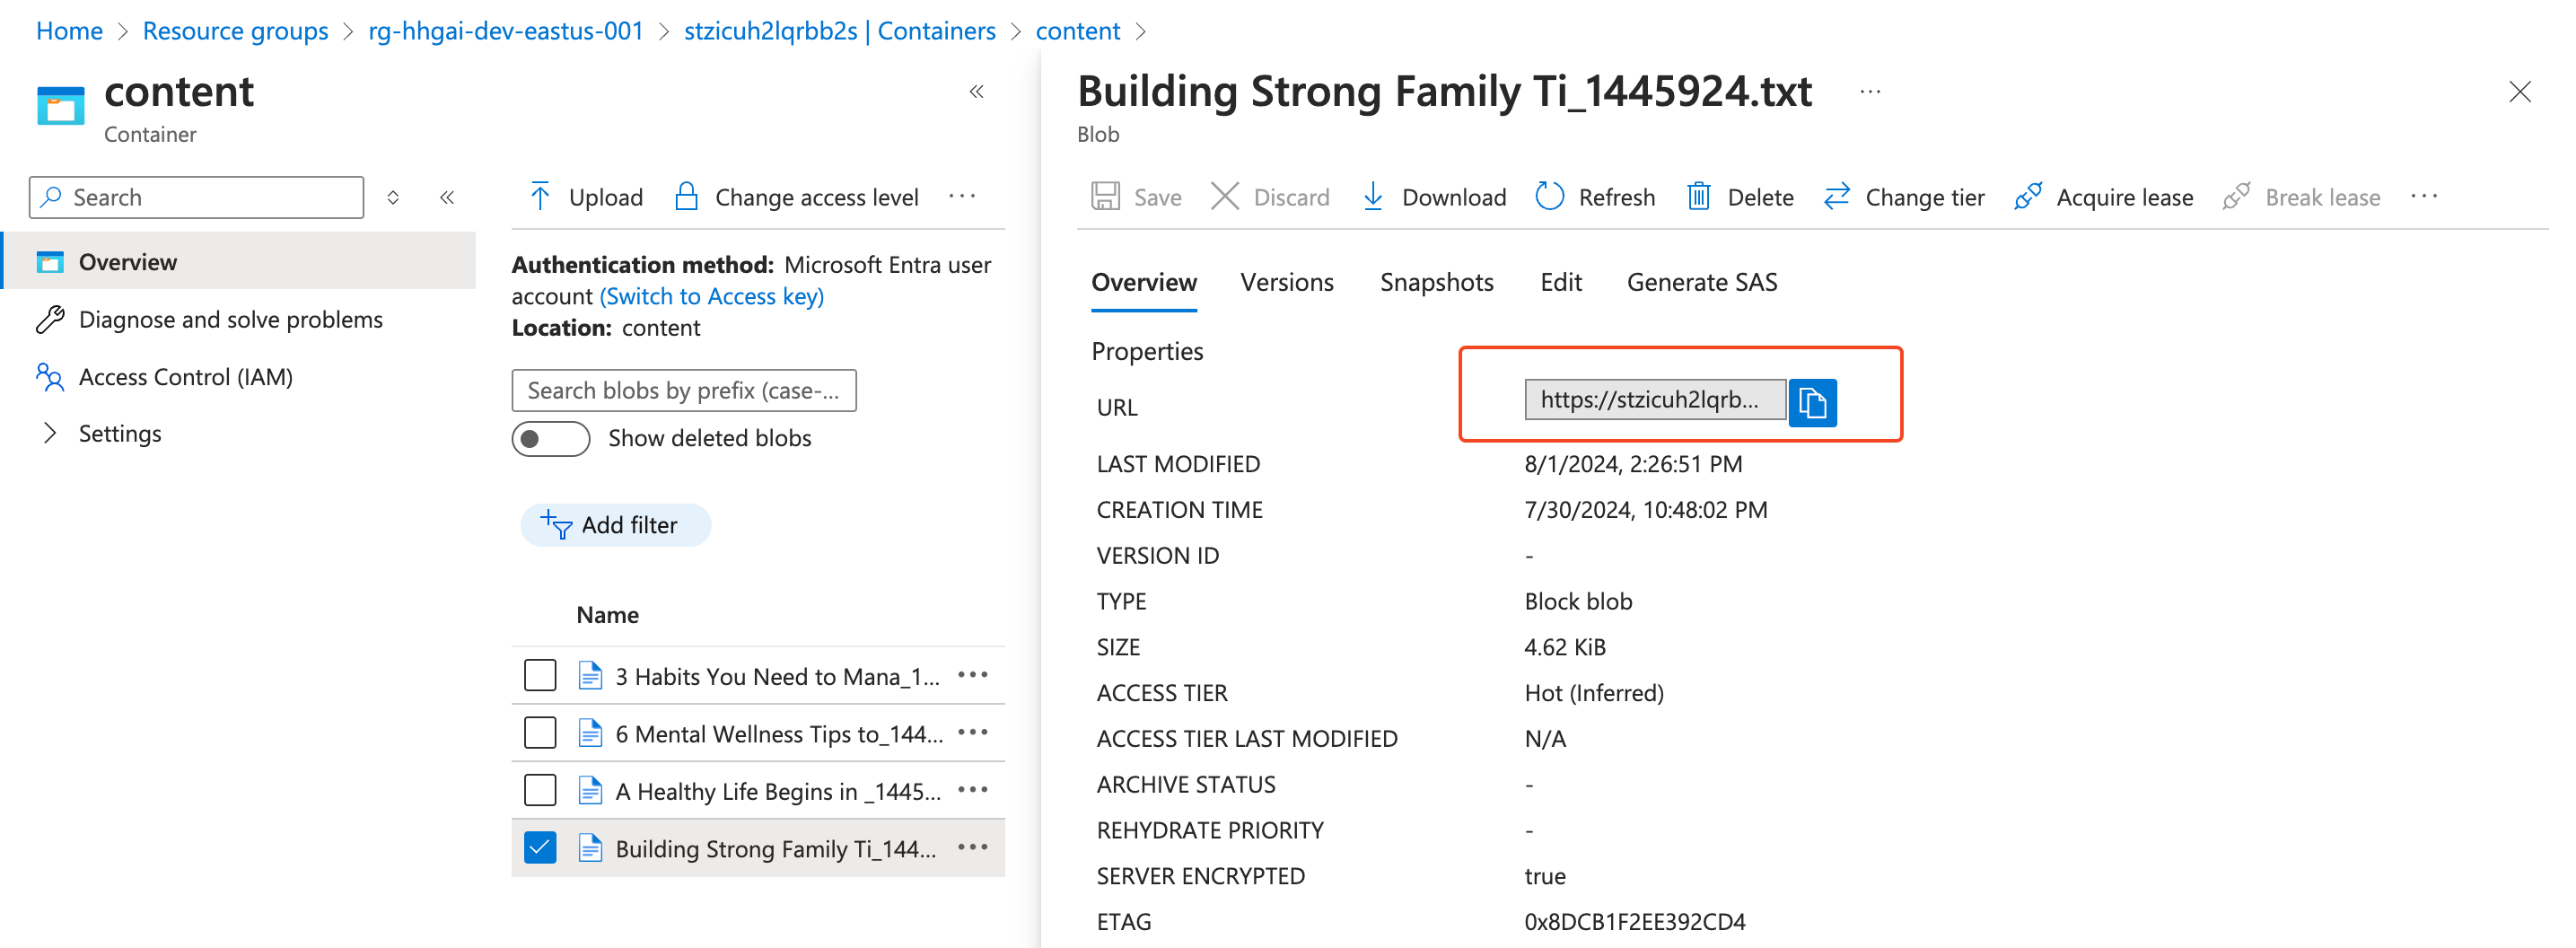


## `Azure OpenAI Service`


We are going to create `Class`es for this service. You may ignore the code below for now. In summary, we will create a parent class that will be inherited from by `AzureOpenAIEmbeddingService`.


In [12]:
class ExtraArgs(TypedDict, total=False):
    dimensions: int


class EmbeddingBatch:
    """
    Represents a batch of text that is going to be embedded
    """

    def __init__(self, texts: list[str], token_length: int):
        self.texts = texts
        self.token_length = token_length


class OpenAIEmbeddings(ABC):
    """
    Contains common logic across both OpenAI and Azure OpenAI embedding services
    Can split source text into batches for more efficient embedding calls
    """

    SUPPORTED_BATCH_AOAI_MODEL = {
        "text-embedding-ada-002": {"token_limit": 8100, "max_batch_size": 16},
        "text-embedding-3-small": {"token_limit": 8100, "max_batch_size": 16},
        "text-embedding-3-large": {"token_limit": 8100, "max_batch_size": 16},
    }

    # See: https://platform.openai.com/docs/guides/embeddings/what-are-embeddings#:~:text=By%20default%2C%20the,case%20section.
    SUPPORTED_DIMENSIONS_MODEL = {
        "text-embedding-ada-002": False,
        "text-embedding-3-small": True,
        "text-embedding-3-large": True,
    }

    def __init__(self, open_ai_model_name: str, open_ai_dimensions: int, disable_batch: bool = False):
        self.open_ai_model_name = open_ai_model_name
        self.open_ai_dimensions = open_ai_dimensions
        self.disable_batch = disable_batch

    async def create_client(self) -> AsyncOpenAI:
        raise NotImplementedError

    def before_retry_sleep(self, retry_state):
        print("Rate limited on the OpenAI embeddings API, sleeping before retrying...")

    def calculate_token_length(self, text: str) -> int:
        encoding = tiktoken.encoding_for_model(self.open_ai_model_name)
        return len(encoding.encode(text))

    def split_text_into_batches(self, texts: list[str]) -> list[EmbeddingBatch]:
        batch_info = OpenAIEmbeddings.SUPPORTED_BATCH_AOAI_MODEL.get(self.open_ai_model_name)
        if not batch_info:
            raise NotImplementedError(
                f"Model {self.open_ai_model_name} is not supported with batch embedding operations"
            )

        batch_token_limit = batch_info["token_limit"]
        batch_max_size = batch_info["max_batch_size"]
        batches: list[EmbeddingBatch] = []
        batch: list[str] = []
        batch_token_length = 0
        for text in texts:
            text_token_length = self.calculate_token_length(text)
            # If the batch_token_length + text_token_length exceeds or is equal to the batch_token_limit
            # and the batch is not empty, add the batch to the list of batches
            if batch_token_length + text_token_length >= batch_token_limit and len(batch) > 0:
                batches.append(EmbeddingBatch(batch, batch_token_length))
                # Reset
                batch = []
                batch_token_length = 0

            batch.append(text)
            batch_token_length += text_token_length
            # If the batch is equal to the batch_max_size, add the batch to the list of batches
            if len(batch) == batch_max_size:
                batches.append(EmbeddingBatch(batch, batch_token_length))
                # Reset
                batch = []
                batch_token_length = 0

        # At the end, check if there are any remaining elements in the batch
        if len(batch) > 0:
            batches.append(EmbeddingBatch(batch, batch_token_length))

        return batches

    async def create_embedding_batch(self, texts: list[str], dimensions_args: ExtraArgs) -> list[list[float]]:
        batches = self.split_text_into_batches(texts)
        embeddings = []
        client = await self.create_client()
        for batch in batches:
            async for attempt in AsyncRetrying(
                retry=retry_if_exception_type(RateLimitError),
                wait=wait_random_exponential(min=15, max=60),
                stop=stop_after_attempt(15),
                before_sleep=self.before_retry_sleep,
            ):
                with attempt:
                    emb_response = await client.embeddings.create(
                        model=self.open_ai_model_name, input=batch.texts, **dimensions_args
                    )
                    embeddings.append([data.embdding for data in emb_response.data])
                    print(
                        "Computed embeddings in batch. Batch size: %d, Token count: %d",
                        len(batch.texts),
                        batch.token_length,
                    )

        return embeddings

    async def create_embedding_single(self, text: str, dimensions_args: ExtraArgs) -> list[float]:
        client = await self.create_client()
        async for attempt in AsyncRetrying(
            retry=retry_if_exception_type(RateLimitError),
            wait=wait_random_exponential(min=15, max=60),
            stop=stop_after_attempt(15),
            before_sleep=self.before_retry_sleep,
        ):
            with attempt:
                emb_response = await client.embeddings.create(
                    model=self.open_ai_model_name, input=text, **dimensions_args
                )
                print("Computed embedding for text section. Character count: %d", len(text))

        return emb_response.data[0].embedding

    async def create_embeddings(self, texts: list[str]) -> list[list[float]]:
        # Only supported in text-embedding-3 and later models.
        dimensions_args: ExtraArgs = (
            {"dimensions": self.open_ai_dimensions}
            if OpenAIEmbeddings.SUPPORTED_DIMENSIONS_MODEL.get(self.open_ai_model_name)
            else {}
        )

        if not self.disable_batch and self.open_ai_model_name in OpenAIEmbeddings.SUPPORTED_BATCH_AOAI_MODEL:
            return await self.create_embedding_batch(texts, dimensions_args)

        return [await self.create_embedding_single(text, dimensions_args) for text in texts]

Now, for the main class for embedding services. It simply implements the `create_client` method which creates the `AsyncAzureOpenAI` Class and inherits the other methods from the parent class above.


In [13]:
class AzureOpenAIEmbeddingService(OpenAIEmbeddings):
    """
    Class for using Azure OpenAI embeddings
    To learn more please visit https://learn.microsoft.com/azure/ai-services/openai/concepts/understand-embeddings
    """

    def __init__(
        self,
        open_ai_service: str | None,
        open_ai_deployment: str | None,
        open_ai_model_name: str,
        open_ai_dimensions: int,
        credential: AsyncTokenCredential | AzureKeyCredential,
        open_ai_custom_url: str | None = None,
        disable_batch: bool = False,
    ):
        super().__init__(open_ai_model_name, open_ai_dimensions, disable_batch)
        self.open_ai_service = open_ai_service
        if open_ai_service:
            self.open_ai_endpoint = f"https://{open_ai_service}.openai.azure.com"
        elif open_ai_custom_url:
            self.open_ai_endpoint = open_ai_custom_url
        else:
            raise ValueError("Either open_ai_service or open_ai_custom_url must be provided")
        self.open_ai_deployment = open_ai_deployment
        self.credential = credential

    async def create_client(self) -> AsyncOpenAI:
        # Specify a Class to hold the authentication parameters
        class AuthArgs(TypedDict, total=False):
            api_key: str
            azure_ad_token_provider: Callable[[], str | Awaitable[str]]

        # Check if API Key was used or Azure AD
        auth_args = AuthArgs()
        # If API Key was used, assign it to AuthArgs
        if isinstance(self.credential, AzureKeyCredential):
            auth_args["api_key"] = self.credential.key
        elif isinstance(self.credential, AsyncTokenCredential):
            auth_args["azure_ad_token_provider"] = get_bearer_token_provider(
                self.credential, "https://cognitiveservices.azure.com/.default"
            )
        else:
            raise TypeError("Invalid credential type")

        return AsyncAzureOpenAI(
            azure_endpoint=self.open_ai_endpoint,
            azure_deployment=self.open_ai_deployment,
            api_version="2023-05-15",
            **auth_args,
        )

In [14]:
open_ai_service: str = os.getenv("AZURE_OPENAI_SERVICE")  # name of search service
open_ai_deployment: str = os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT")  # name of deployment
open_ai_model_name: str = os.getenv("AZURE_OPENAI_EMB_MODEL_NAME")  # name of the embedding model
open_ai_dimensions: int = 1536  # dimensionality of the embeddings
disable_batch_vectors: bool = False
openai_key: str | None = None  # we're not using keys

# Use the current user identity to connect to Azure services unless a key is explicitly set for any of them
azure_credential = (
    AzureDeveloperCliCredential()
    if tenantid is None
    else AzureDeveloperCliCredential(tenant_id=tenantid, process_timeout=60)
)

azure_open_ai_credential: AsyncTokenCredential | AzureKeyCredential = (
    azure_credential if openai_key is None else AzureKeyCredential(openai_key)
)

embeddings = AzureOpenAIEmbeddingService(
    open_ai_service=open_ai_service,
    open_ai_custom_url=None,
    open_ai_deployment=open_ai_deployment,
    open_ai_model_name=open_ai_model_name,
    open_ai_dimensions=open_ai_dimensions,
    credential=azure_open_ai_credential,
    disable_batch=disable_batch_vectors,
)

In [15]:
dimensions_args: ExtraArgs = (
    {"dimensions": embeddings.open_ai_dimensions}
    if OpenAIEmbeddings.SUPPORTED_DIMENSIONS_MODEL.get(embeddings.open_ai_model_name)
    else {}
)

print(dimensions_args)

{}


Please only run the following cell when needed — it costs money.


In [16]:
# single_embedding = await embeddings.create_embedding_single("hello world", dimensions_args)
# len(single_embedding)

## `Azure AI Search`


### `SearchClient`, `SearchIndexClient`, `SearchIndexerClient`


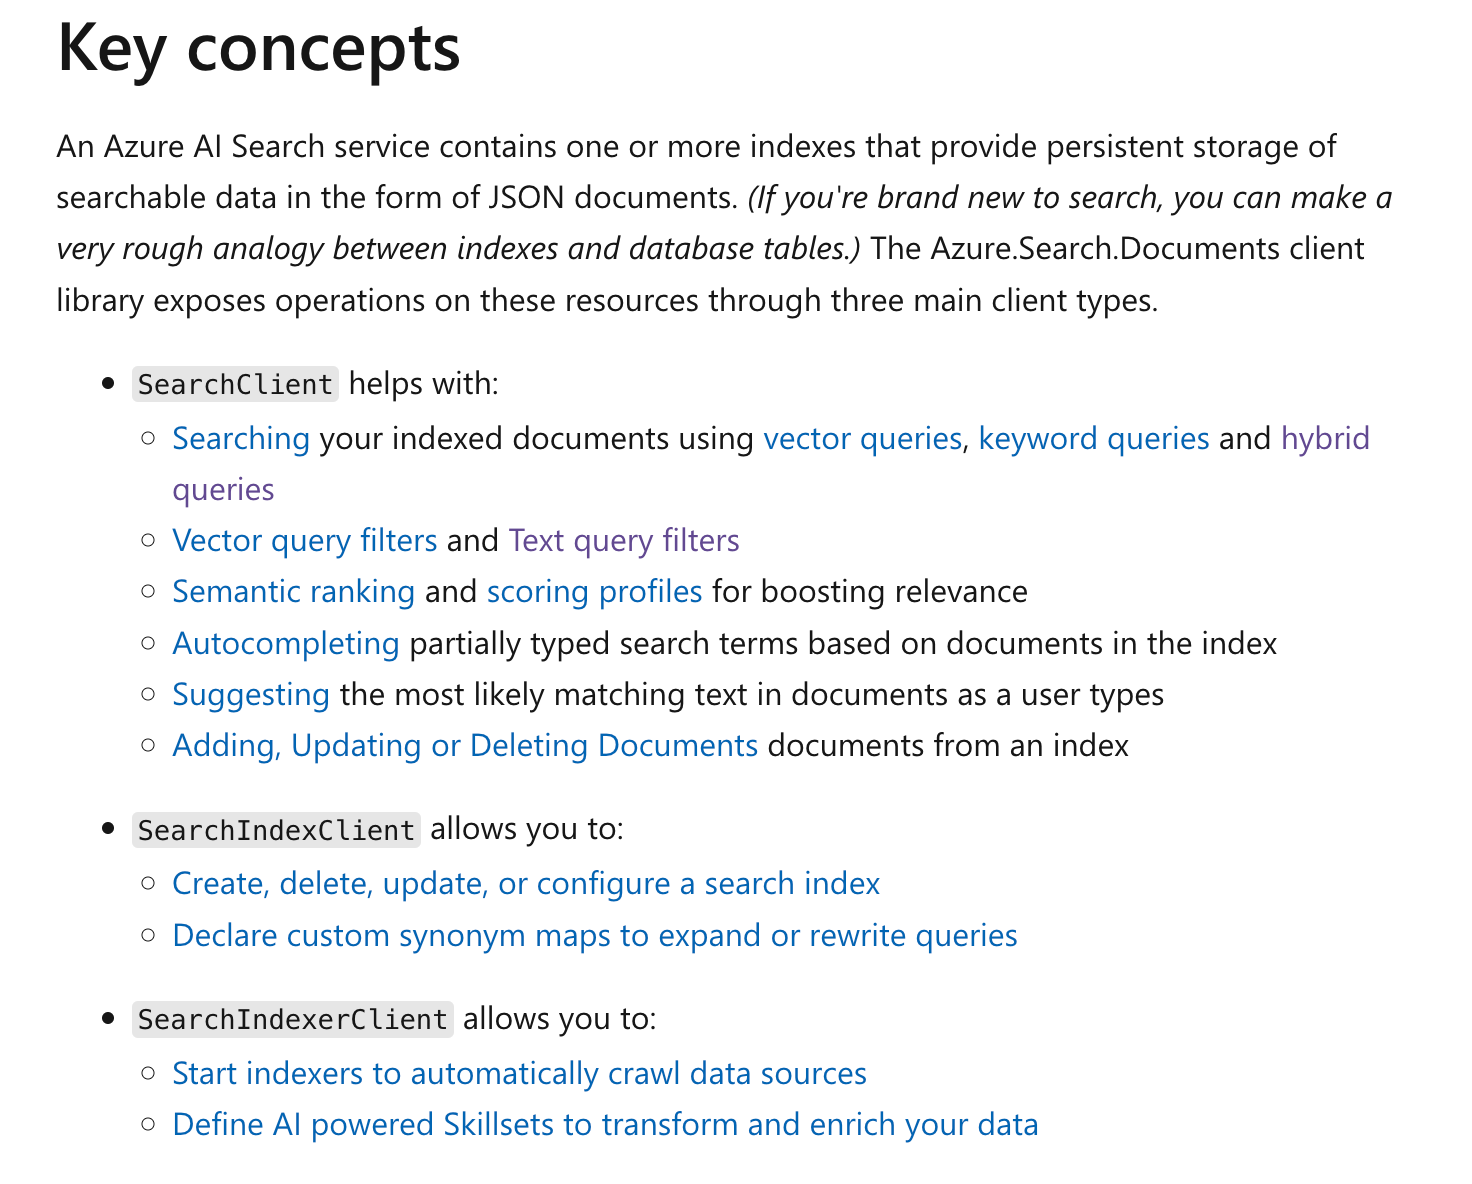

- `SearchClient`: for searching indexed documents.

- `SearchIndexClient`: for managing indexes.

- `SearchIndexerClient`: for crawling data sources and loading search documents into an index.


In [17]:
search_service = os.getenv("AZURE_SEARCH_SERVICE")  # name of search service
# index = os.getenv("AZURE_SEARCH_INDEX")  # name of index
index_name = "gptkbindextmp"  # please use a temporary index name for testing
tenantid: str | None = os.getenv("AZURE_TENANT_ID")  # None
search_key = None  # we're not using keys

# Use the current user identity to connect to Azure services unless a key is explicitly set for any of them
azure_credential = (
    AzureDeveloperCliCredential()
    if tenantid is None
    else AzureDeveloperCliCredential(tenant_id=tenantid, process_timeout=60)
)

search_creds: AsyncTokenCredential | str = azure_credential if search_key is None else search_key

Common way to instantiate the clients:

```python
# Search client
search_client = SearchClient(
    endpoint=f"https://{search_service}.search.windows.net/", index_name=index, credential=search_creds
)
# Search index client
search_index_client = SearchIndexClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
)
# Search indexer client
search_indexer_client = SearchIndexerClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
)
```

However, we will be using the asynchronous context managers (see below) to instantiate the clients instead.


### `SearchIndexClient`


### Removing an index


Before we create the temporary index, we need to remove it if it exists.


In [18]:
async with SearchIndexClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
) as search_index_client:
    if index_name in [name async for name in search_index_client.list_index_names()]:
        print("Deleting %s search index", index_name)
        await search_index_client.delete_index(index_name)
    else:
        print("Search index %s does not exist", index_name)

Search index %s does not exist gptkbindextmp


### Creating an index


Before we create an index, we first have to specify the fields in the index.

- **searchable:** Allows full-text search on the field.

- **filterable:** Allows filtering based on exact matches or ranges.

- **sortable:** Allows sorting of search results.

- **facetable**: Allows the creation of facets for refining search results.


### Specify the fields

These are the fields the index will have.


In [19]:
use_int_vectorization: bool = True
analyzer_name: str | None = "en.microsoft"

fields = [
    (
        SimpleField(name="id", type="Edm.String", key=True)
        if not use_int_vectorization
        else SearchField(
            name="id",
            type="Edm.String",
            key=True,
            sortable=True,
            filterable=True,
            facetable=True,
            # Treats the entire content of a field as a single token.
            # Useful for exact match searches, identifiers, URLs, codes, or tags.
            # Does not split text into multiple tokens based on whitespace or punctuation.
            analyzer_name="keyword",
        )
    ),
    SearchableField(
        name="content",
        type="Edm.String",
        # See: https://stackoverflow.com/questions/2705670/how-does-lucene-work
        analyzer_name="en.lucene" if analyzer_name is None else analyzer_name,
    ),
    SearchField(
        name="embedding",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),  # "Collection(Edm.Single)"
        hidden=False,
        searchable=True,
        filterable=False,
        sortable=False,
        facetable=False,
        # Integrated vectorization uses the ada-002 model with 1536 dimensions
        vector_search_dimensions=embeddings.open_ai_dimensions,
        vector_search_profile_name="embedding_config",
    ),
    SimpleField(name="category", type="Edm.String", filterable=True, facetable=True),
    SimpleField(
        name="sourcePage",
        type="Edm.String",
        filterable=True,
        facetable=True,
    ),
    SimpleField(
        name="sourceFile",
        type="Edm.String",
        filterable=True,
        facetable=True,
    ),
    SimpleField(
        name="storageUrl",
        type="Edm.String",
        filterable=True,
        facetable=False,
    ),
]

if use_int_vectorization:
    fields.append(SearchableField(name="parent_id", type="Edm.String", filterable=True))

In [20]:
# Vectorizer used to compute the embeddings
vectorizers: VectorSearchVectorizer = AzureOpenAIVectorizer(
    name=f"{index_name}-vectorizer",
    kind="azureOpenAI",
    azure_open_ai_parameters=AzureOpenAIParameters(
        resource_uri=f"https://{embeddings.open_ai_service}.openai.azure.com",
        deployment_id=embeddings.open_ai_deployment,
    ),
)


index = SearchIndex(
    name=index_name,  # the temporary index name
    fields=fields,
    semantic_search=SemanticSearch(
        configurations=[
            SemanticConfiguration(
                name="default",
                prioritized_fields=SemanticPrioritizedFields(
                    title_field=None, content_fields=[SemanticField(field_name="content")]
                ),
            )
        ]
    ),
    vector_search=VectorSearch(
        # Algorithm used for vector search
        algorithms=[HnswAlgorithmConfiguration(name="hnsw_config", parameters=HnswParameters(metric="cosine"))],
        # Specify the profiles for the vector search and computing the embeddings
        profiles=[
            VectorSearchProfile(
                name="embedding_config",
                algorithm_configuration_name="hnsw_config",
                vectorizer=(f"{index_name}-vectorizer" if use_int_vectorization else None),
            ),
        ],
        vectorizers=[vectorizers],
    ),
)

### List (existing) index names


In [21]:
async with SearchIndexClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
) as search_index_client:
    index_names = [name async for name in search_index_client.list_index_names()]
    print(index_names)

['gptkbindex']


In [22]:
print("Ensuring search index %s exists", index_name)

# Using context manager to get search index client to manage indexes
async with SearchIndexClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
) as search_index_client:
    # list_index_names returns an AsyncIterable hence the syntax
    if index_name not in [name async for name in search_index_client.list_index_names()]:
        # Our temporary index does not exist, so we will create it
        print("Creating %s search index", index_name)
        await search_index_client.create_index(index)
    else:
        print("Search index %s already exists", index_name)
        index_definition = await search_index_client.get_index(index_name)
        if not any(field.name == "storageUrl" for field in index_definition.fields):
            print("Adding storageUrl field to search index %s", index_name)
            index_definition.fields.append(
                SimpleField(
                    name="storageUrl",
                    type="Edm.String",
                    filterable=True,
                    facetable=False,
                ),
            )
            await search_index_client.create_or_update_index(index_definition)

Ensuring search index %s exists gptkbindextmp
Creating %s search index gptkbindextmp


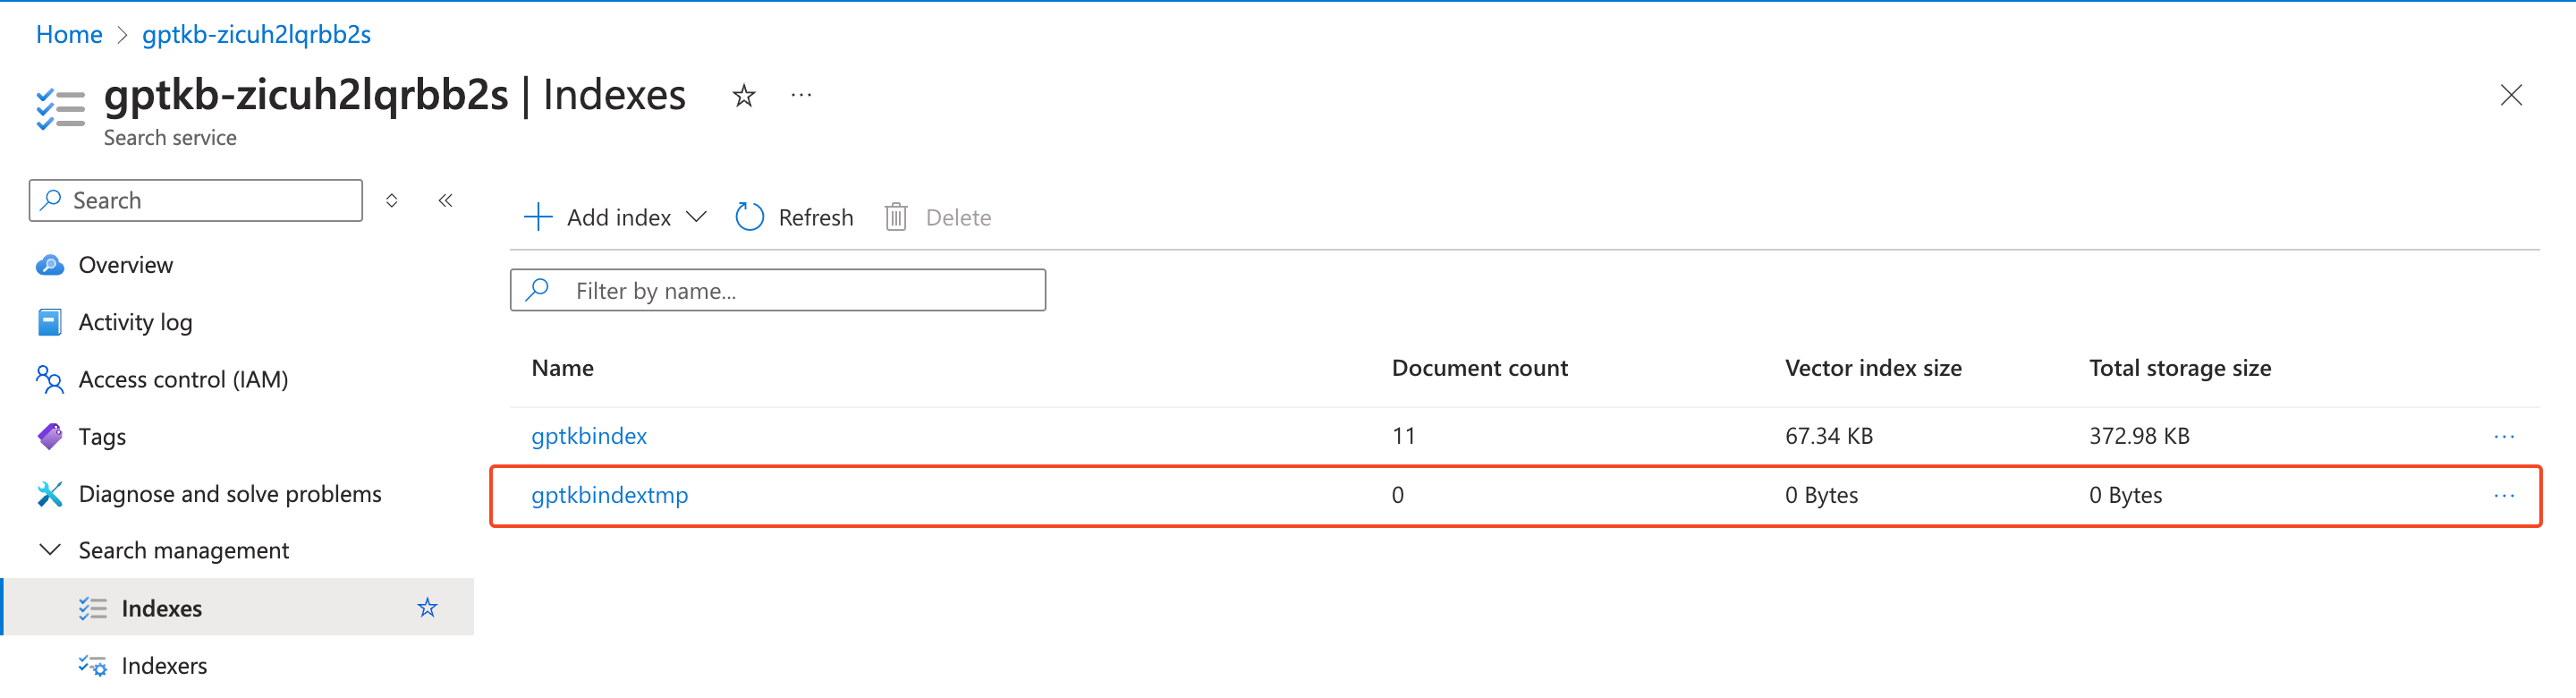


### `SearchIndexerClient`


### Establishing a connection to the blob storage (data source)


We'll first specify some utility functions. You may feel free to ignore these for now but the functions essentially do the following resepctively:

1. Generates a managed identity connection string for storage account.

   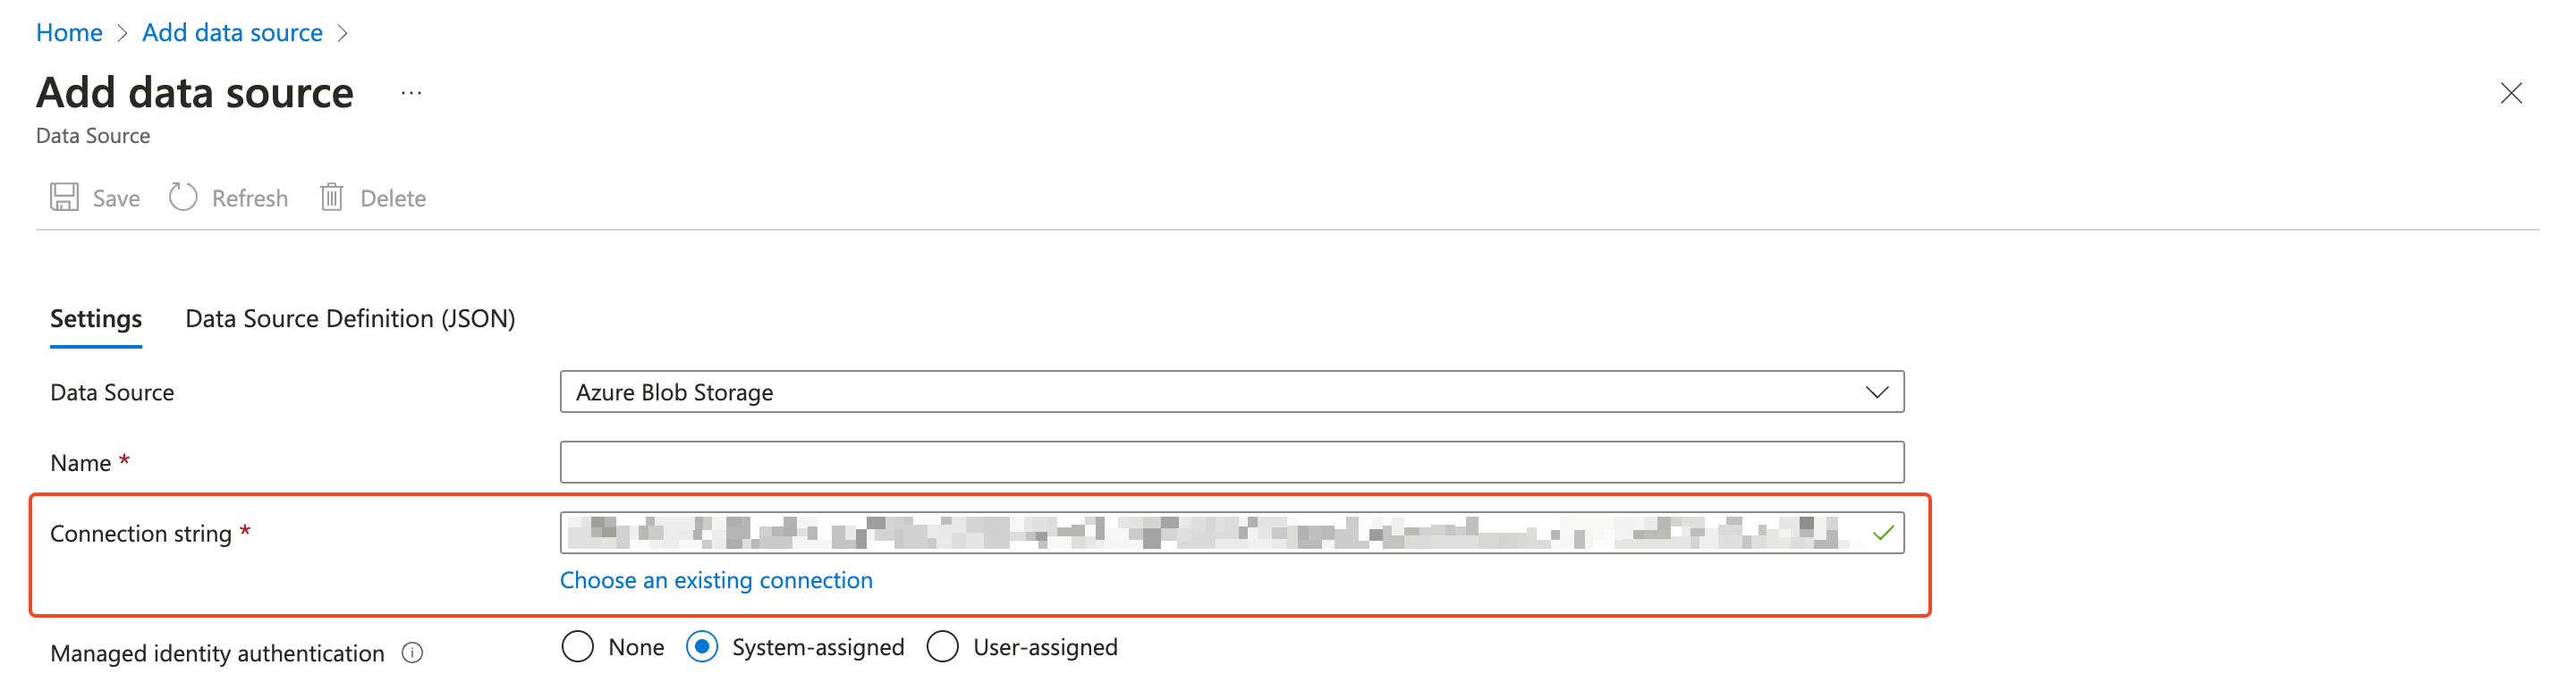

2. Creates a skillset (collection of skills)

   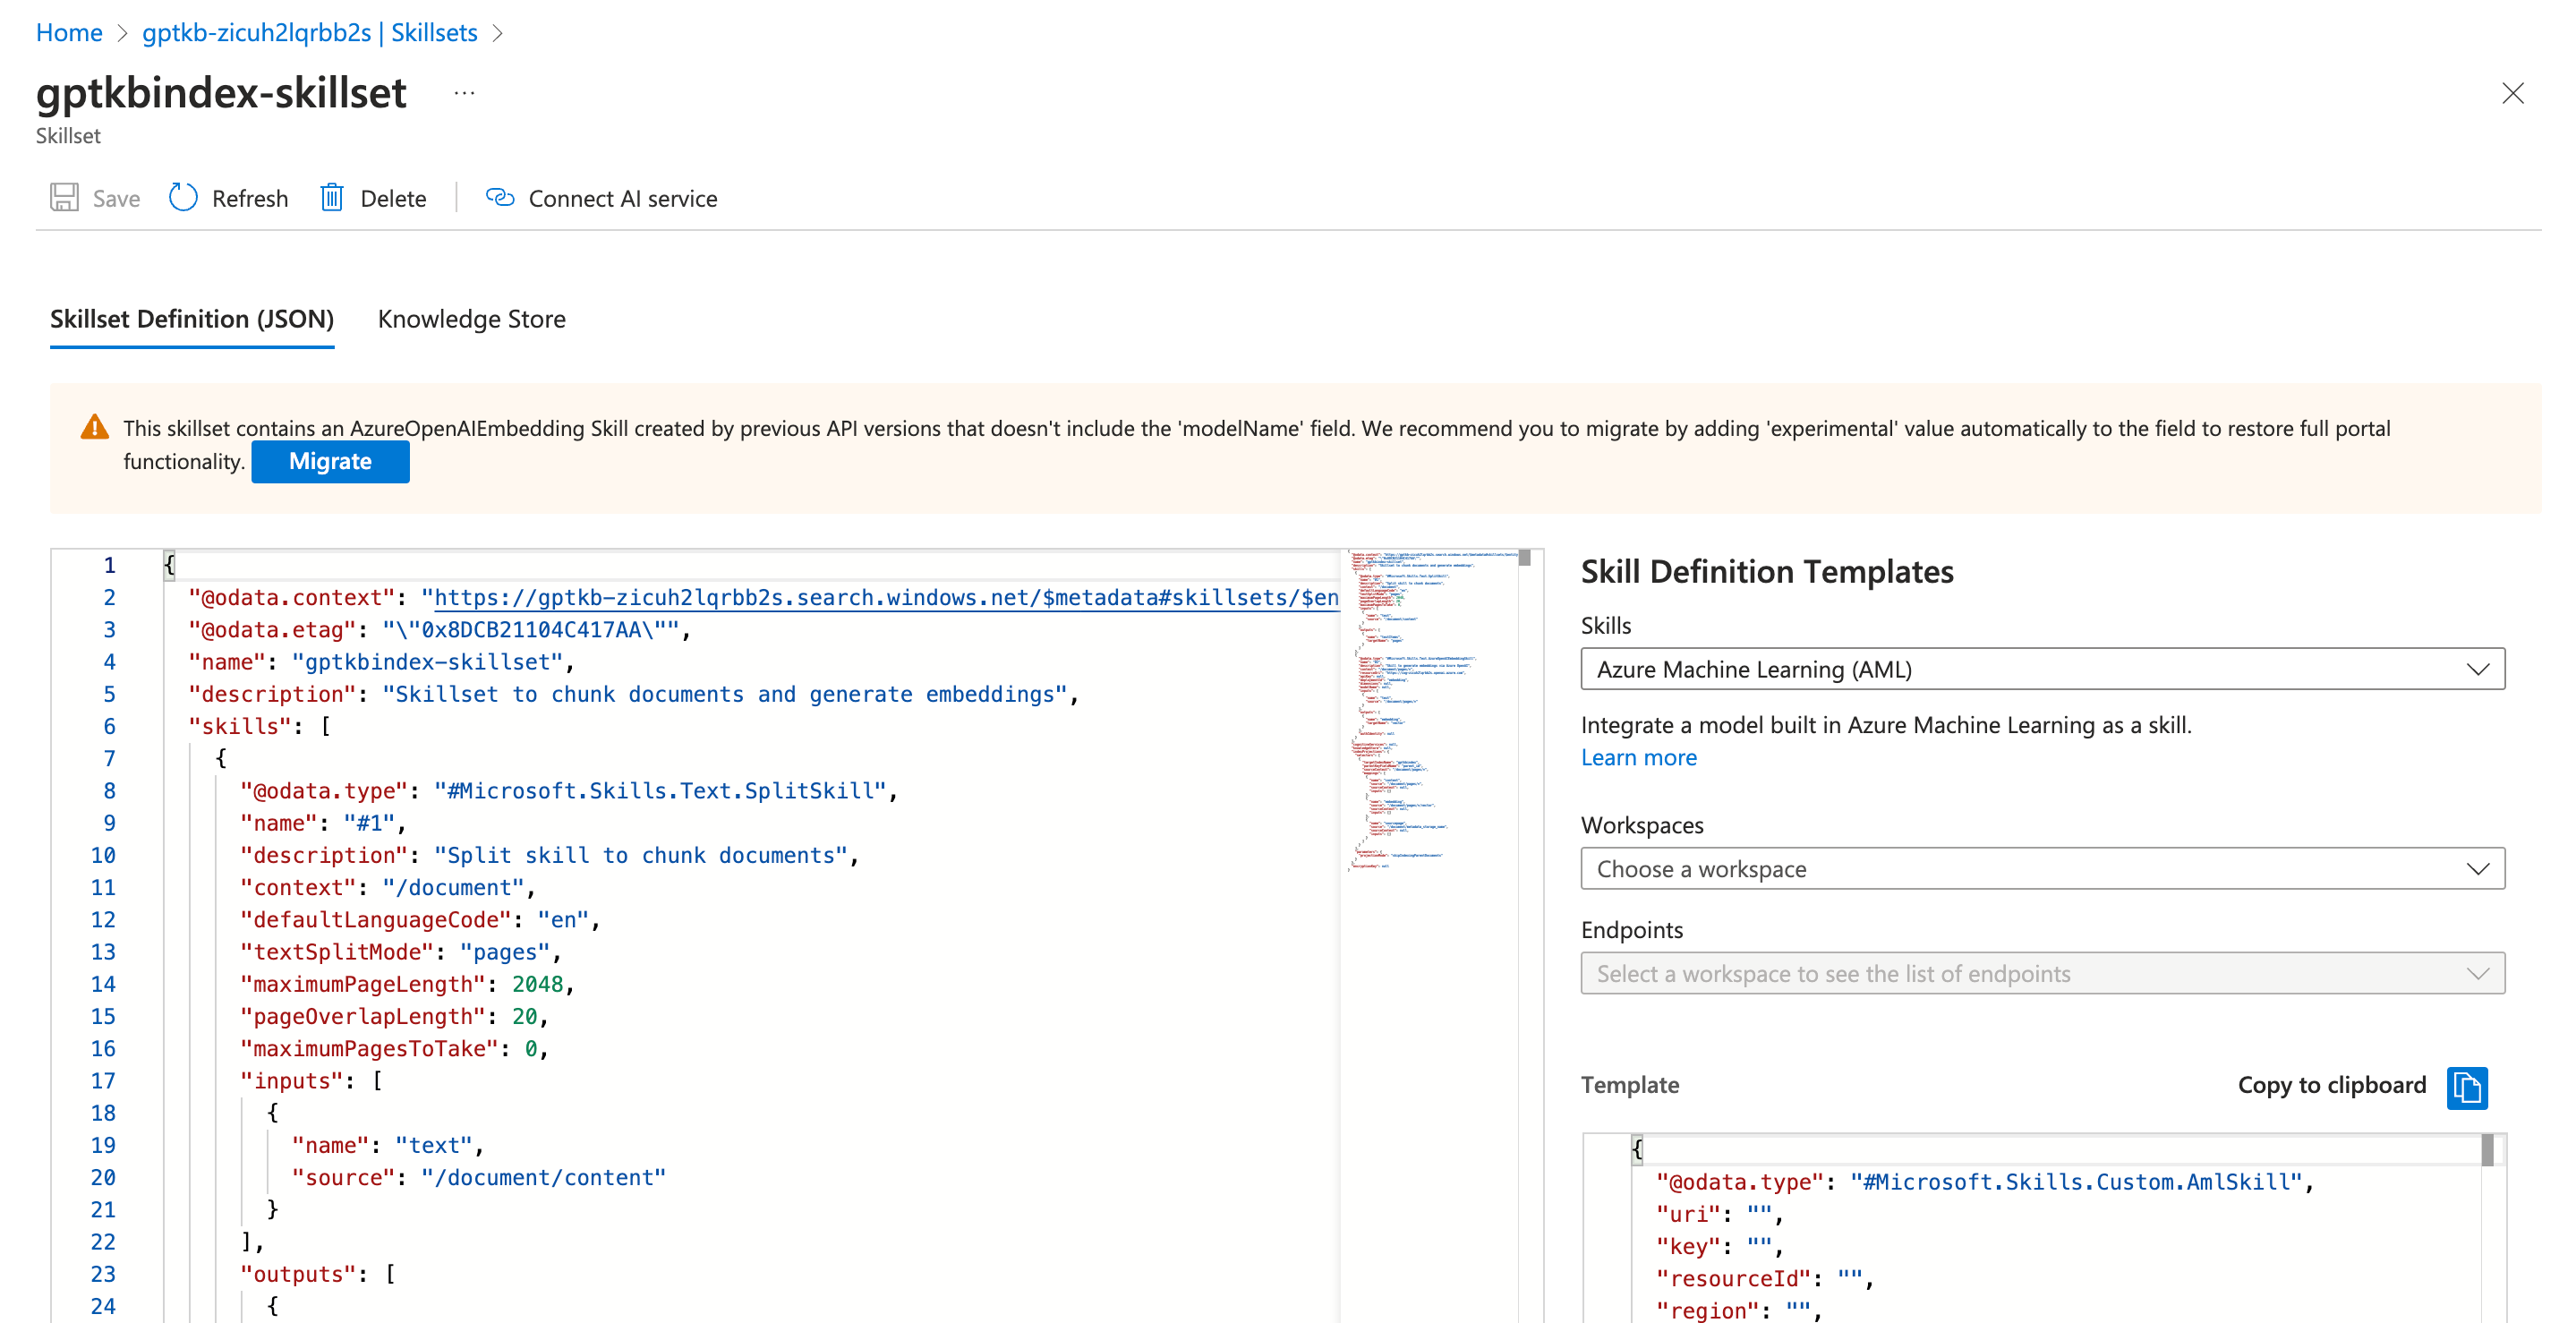


In [31]:
def get_managed_identity_connection_string() -> str:
    """Get managed identity connection string for storage account"""
    return f"ResourceId=/subscriptions/{os.getenv('AZURE_SUBSCRIPTION_ID')}/resourceGroups/{os.getenv('AZURE_RESOURCE_GROUP')}/providers/Microsoft.Storage/storageAccounts/{os.getenv('AZURE_STORAGE_ACCOUNT')};"


async def create_embedding_skill(index_name: str) -> tuple[str, SearchIndexerSkillset]:
    skillset_name = f"{index_name}-skillset"

    split_skill = SplitSkill(
        description="Split skill to chunk documents",
        text_split_mode="pages",  # or sentences
        context="/document",
        maximum_page_length=2048,
        page_overlap_length=20,  # number of characters/tokens
        inputs=[InputFieldMappingEntry(name="text", source="/document/content")],
        outputs=[OutputFieldMappingEntry(name="textItems", target_name="pages")],
    )

    if embeddings is None:
        raise ValueError("Expecting Azure Open AI instance")

    embedding_skill = AzureOpenAIEmbeddingSkill(
        description="Skill to generate embeddings via Azure OpenAI",
        context="/document/pages/*",
        resource_uri=f"https://{embeddings.open_ai_service}.openai.azure.com",
        deployment_id=embeddings.open_ai_deployment,
        inputs=[InputFieldMappingEntry(name="text", source="/document/pages/*")],
        outputs=[OutputFieldMappingEntry(name="embedding", target_name="vector")],
    )

    index_projections = SearchIndexerIndexProjections(
        selectors=[
            SearchIndexerIndexProjectionSelector(
                target_index_name=index_name,
                parent_key_field_name="parent_id",
                source_context="/document/pages/*",
                mappings=[
                    # Maps the outputs from the indexer to the fields in the index
                    InputFieldMappingEntry(name="content", source="/document/pages/*"),
                    InputFieldMappingEntry(name="embedding", source="/document/pages/*/vector"),
                    InputFieldMappingEntry(name="sourcePage", source="/document/metadata_storage_name"),
                ],
            )
        ],
        parameters=SearchIndexerIndexProjectionsParameters(
            # Source document will be skipped from writing into the indexer's target index
            projection_mode=IndexProjectionMode.SKIP_INDEXING_PARENT_DOCUMENTS  # or INCLUDE_INDEXING_PARENT_DOCUMENTS
        ),
    )

    skillset = SearchIndexerSkillset(
        name=skillset_name,
        description="Skillset to chunk documents and generate embeddings",
        skills=[split_skill, embedding_skill],
        index_projections=index_projections,
    )

    return skillset_name, skillset

In [32]:
async with SearchIndexerClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
) as search_indexer_client:
    ds_container = SearchIndexerDataContainer(name=container)  # the container name in the blob storage
    ds_connection = SearchIndexerDataSourceConnection(
        name=f"{index_name}-blob",
        type="azureblob",
        connection_string=get_managed_identity_connection_string(),
        container=ds_container,
        data_deletion_detection_policy=NativeBlobSoftDeleteDeletionDetectionPolicy(),
    )

    try:
        await search_indexer_client.create_or_update_data_source_connection(ds_connection)
        print("Search indexer data source connection updated.")
    except ResourceExistsError:
        print("Search indexer data source connection already exists. Nothing to be updated.")

    skillset_name, embedding_skillset = await create_embedding_skill(index_name=index_name)
    await search_indexer_client.create_or_update_skillset(embedding_skillset)
    # await ds_client.close()  # you'd have to explicitly call this if you're not using a context manager

Search indexer data source connection already exists. Nothing to be updated.


### Creating an indexer


In [33]:
indexer_name = f"{index_name}-indexer"

indexer = SearchIndexer(
    name=indexer_name,
    description="Indexer to index documents and generate embeddings",
    skillset_name=skillset_name,  # the name of the skillset
    target_index_name=index_name,  # the name of the target index
    data_source_name=f"{index_name}-blob",  # the name of the data source connection
    # Map the metadata_storage_name field to the sourcePage field in the index
    field_mappings=[
        FieldMapping(source_field_name="metadata_storage_name", target_field_name="title"),
    ],
)

async with SearchIndexerClient(
    endpoint=f"https://{search_service}.search.windows.net/", credential=search_creds
) as search_indexer_client:
    indexer_result = await search_indexer_client.create_or_update_indexer(indexer)
    # Run the indexer
    await search_indexer_client.run_indexer(indexer_name)
    # await search_indexer_client.close()   # you'd have to explicitly call this if you're not using a context manager

print(
    f"Successfully created index, indexer: {indexer_result.name}, and skillset. "
    "Please navigate to search service in Azure Portal to view the status of the indexer."
)

Successfully created index, indexer: gptkbindextmp-indexer, and skillset. Please navigate to search service in Azure Portal to view the status of the indexer.
